Data Source: https://archive.ics.uci.edu/dataset/732/darwin<br>
<br>
The DARWIN dataset includes handwriting data from 174 participants. The classification task consists in distinguishing Alzheimer’s disease patients from healthy people.<br>
<br>
Dataset Characteristics<br>
Tabular
<br>
Subject Area<br>
Health and Medicine<br>
<br>
Associated Tasks<br>
Classification<br>
<br>
Feature Type<br>
-<br>
<br>
Number of Instances<br>
174<br>
<br>
Number of Features<br>
451<br>

Source of Original Paper: <br>
* https://www.sciencedirect.com/science/article/abs/pii/S0952197622000902

### Note: this data set has more features than instances

## A comment on the absent yaml file:
I had the intention to provide a minimal yaml file in the repo - the minimal installation necessary to run the notebook. Unfortunately matplotlib.pyplot calls PIL somewhen -- the major pain-in-the-ass library in the python universe with a record of more then 10 years of installation problems of all kinds. <br>
After spending 3 hours trying to find/ fix the installation error (instead of doing something usefull) - I decided to go with my working kernel that is allready hopelessly overloaded with installed libraries - I am sure You do not want to install everything that is in it - at least I wouldn't. <br> 
Sorry, no yaml this time!


## Data Loading

In [1]:
# installer from uci:

# pip install ucimlrepo

In [2]:
# execute this cell to load the dataset from the internet into X and y (each time you execute this)
""" 
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
darwin = fetch_ucirepo(id=732) 
  
# data (as pandas dataframes) 
X = darwin.data.features 
y = darwin.data.targets 
  
# metadata 
print(darwin.metadata) 
  
# variable information 
print(darwin.variables)  
"""


' \nfrom ucimlrepo import fetch_ucirepo \n  \n# fetch dataset \ndarwin = fetch_ucirepo(id=732) \n  \n# data (as pandas dataframes) \nX = darwin.data.features \ny = darwin.data.targets \n  \n# metadata \nprint(darwin.metadata) \n  \n# variable information \nprint(darwin.variables)  \n'

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

#columns = [...]
sourcepath = Path(r".\Data\DARWIN\DARWIN\DARWIN.csv".replace("\\", "/"))
data = pd.read_csv(sourcepath)

data.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


The column with name "class" seems to be the target variable.

### Class distribution

<BarContainer object of 2 artists>

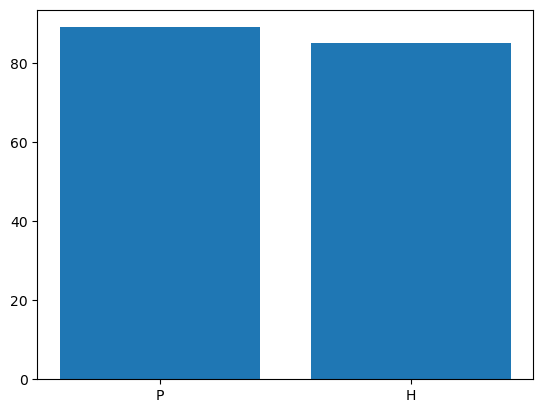

In [4]:
import matplotlib.pyplot as plt

ps = data.loc[data["class"] == "P"].shape[0]
hs = data.loc[data["class"] == "H"].shape[0]
plt.bar(["P","H"], [ps, hs])

So the classes are balanced in the data

In [5]:
data.isna().sum()

ID                 0
air_time1          0
disp_index1        0
gmrt_in_air1       0
gmrt_on_paper1     0
                  ..
paper_time25       0
pressure_mean25    0
pressure_var25     0
total_time25       0
class              0
Length: 452, dtype: int64

We have no missing values.

## Lots of features - we need dimension reduction:
1. do a PCA and throw away the dimension with a contribution below a certain threshold: see AlszDiseasePrediction.ipynb
2. try Boruta: this note-book

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score ,recall_score, precision_score, f1_score 
from sklearn.decomposition import PCA
import xgboost as xgb

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Take a look at data of type "object" - as this might demand special handling:

In [7]:
object_cols = data.select_dtypes(include='object').columns.tolist()
# print the column names
print(object_cols)

['ID', 'class']


Remove uninformative ID column and 0, 1 endode H and P classes:

In [8]:
data.drop('ID',axis = 1 , inplace = True)
data["class"].replace({"H": 0, "P": 1}, inplace=True)

Split input from output data and split both in training- and test-data

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop('class',axis = 1)
y = data['class']
X_train , X_test , y_train , y_test = train_test_split(X,y,train_size = 0.8,random_state = 11)

In [10]:
from boruta import BorutaPy

In [11]:
# Create an XGBoost model
xgb_model = xgb.XGBClassifier( objective ='binary:logistic', max_depth = 4, learning_rate = 0.01, n_estimators = 400 )

# Initialize Boruta
boruta = BorutaPy(xgb_model, n_estimators='auto', verbose=False, random_state=1)

# Fit Boruta on the dataset
boruta.fit(X.values, y)

# Print results
""" print("Selected features:")
print(X.columns[boruta.support_].tolist())
print("Tentative features:")
print(X.columns[boruta.support_weak_].tolist()) """


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

[20:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\sit

' print("Selected features:")\nprint(X.columns[boruta.support_].tolist())\nprint("Tentative features:")\nprint(X.columns[boruta.support_weak_].tolist()) '

In [12]:
# Create a DataFrame to display the feature importance
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': boruta.ranking_,
    'Selected': boruta.support_
})

# Sort by feature importance
feature_ranking.sort_values(by='Ranking', inplace=True)

print(feature_ranking)


                  Feature  Ranking  Selected
446          paper_time25        1      True
44             mean_gmrt3        1      True
413          total_time23        1      True
289          disp_index17        2     False
327       gmrt_on_paper19        3     False
..                    ...      ...       ...
203     max_y_extension12      371     False
345       gmrt_on_paper20      371     False
201       gmrt_on_paper12      371     False
156  mean_speed_on_paper9      371     False
224           mean_gmrt13      371     False

[450 rows x 3 columns]


In [13]:
feature_ranking.set_index("Feature", inplace=True)
most_important_features = feature_ranking[feature_ranking["Ranking"] <= 3].index
most_important_features

Index(['paper_time25', 'mean_gmrt3', 'total_time23', 'disp_index17',
       'gmrt_on_paper19'],
      dtype='object', name='Feature')

In [14]:
X_feature_train = X_train[most_important_features]
X_feature_test = X_test[most_important_features]

In [15]:
xgb_classifier = xgb.XGBClassifier( objective ='binary:logistic', max_depth = 4, learning_rate = 0.01, n_estimators = 400 )
xgb_classifier.fit(X_feature_train, y_train)
y_feature_pred = xgb_classifier.predict(X_feature_test)

[20:57:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<Figure size 1000x500 with 0 Axes>

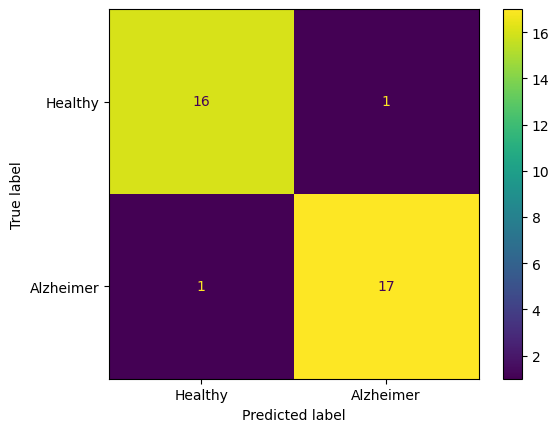

In [16]:
# Creating the confusion matrix 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef

confusion_matrix =confusion_matrix(y_test, y_feature_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Healthy", "Alzheimer"])
plt.figure(figsize = (10,5))
cm_display.plot()
plt.show()

In [17]:
# Checking the F1 score of the model
f1 = f1_score(y_test, y_feature_pred)
print(f"{f1:.3}")

0.944


In [46]:
mcc = matthews_corrcoef(y_true=y_test, y_pred=y_feature_pred)
print(f"{mcc:.3}")

0.886


This result of F1_score = 0.944 and MCC=0.886 looks quite impressive. <br>
But if we look on the most important features found by the Boruta-Algorithm, we find: <br>
<br>
'paper_time25', 'mean_gmrt3', 'total_time23', 'disp_index17', 'gmrt_on_paper19' <br>
<br>
and the question arrises: what makes these feature so important? Is there any explanation, any "mechanism" that makes their importance understandable? <br>
If we don't have such an explanation (and I guess there is none) then the result is just a statistical effect and we probably should not trust this model <br>
despite it's impressive F1 and MCC values.<br>